# Análisis Automatizado de Algoritmos de Ordenamiento
Este notebook realiza un análisis comparativo de la complejidad de los algoritmos **Bubble Sort**, **Insertion Sort** y **Quicksort**.

1. Benchmarking automatizado con múltiples intentos.
2. Cálculo de la desviación estándar.
3. Gráficas de complejidad.
4. Análisis de regresión lineal para validar la complejidad teórica.

In [25]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Importar los algoritmos
from sort.bubble_sort import bubble_sort
from sort.insertion_sort import insertion_sort
from sort.quicksort import quicksort

sns.set_theme(style="whitegrid")

## 1. Benchmarking Automatizado
Definimos una función para medir el tiempo de ejecución con múltiples intentos por cada tamaño de entrada ($n$).

In [ ]:
def measure_time(S, sort_function):
    S_copy = S.copy()
    start_time = time.perf_counter_ns()
    sort_function(S_copy)
    end_time = time.perf_counter_ns()
    return end_time - start_time

def benchmark_algorithms(sizes, trials=10):
    results = []
    for n in sizes:
        print(f"Procesando n={n}...", end="\r")
        for _ in range(trials):
            S = random.sample(range(10*n), n)
            results.append({
                'n': n,
                'Bubble Sort': measure_time(S, bubble_sort),
                'Insertion Sort': measure_time(S, insertion_sort),
                'Quicksort': measure_time(S, quicksort)
            })
    print("\nBenchmarking completado.")
    return pd.DataFrame(results)

# Tamaños de entrada para el análisis
sizes = [10, 50, 100, 250, 500, 750, 1000]
random.shuffle(sizes)
df_raw = benchmark_algorithms(sizes, trials=10)

Procesando n=1000...
Benchmarking completado.


## 2. Análisis Estadístico (Promedio y Desviación Estándar)
Agrupamos los datos por $n$ para calcular el promedio y la desviación estándar.

In [27]:
df_stats = df_raw.groupby('n').agg(['mean', 'std']).reset_index()
df_stats.columns = ['n', 'bubble_mean', 'bubble_std', 'insertion_mean', 'insertion_std', 'quicksort_mean', 'quicksort_std']

df_stats

,n,bubble_mean,bubble_std,insertion_mean,insertion_std,quicksort_mean,quicksort_std
0,10,12926.5,2.140501e+03,5252.5,1524.479018,14867.8,2084.723632
1,50,273556.3,8.878528e+04,79471.9,20939.741675,97271.3,24569.580795
2,100,963932.3,2.357666e+05,229863.5,31841.994083,174702.5,15541.465613
3,250,5592707.0,2.288686e+06,1441327.7,622625.784158,427362.5,178303.881440
4,500,8743116.0,2.299478e+06,2171096.0,770174.440380,342467.6,143562.779458
5,750,19730501.1,4.661591e+05,5096598.2,88989.534590,548590.8,16862.688074
6,1000,35706516.8,4.728988e+05,9269868.7,350623.380973,718713.1,12044.466645


### Gráfica de Tiempos de Ejecución con Desviación Estándar

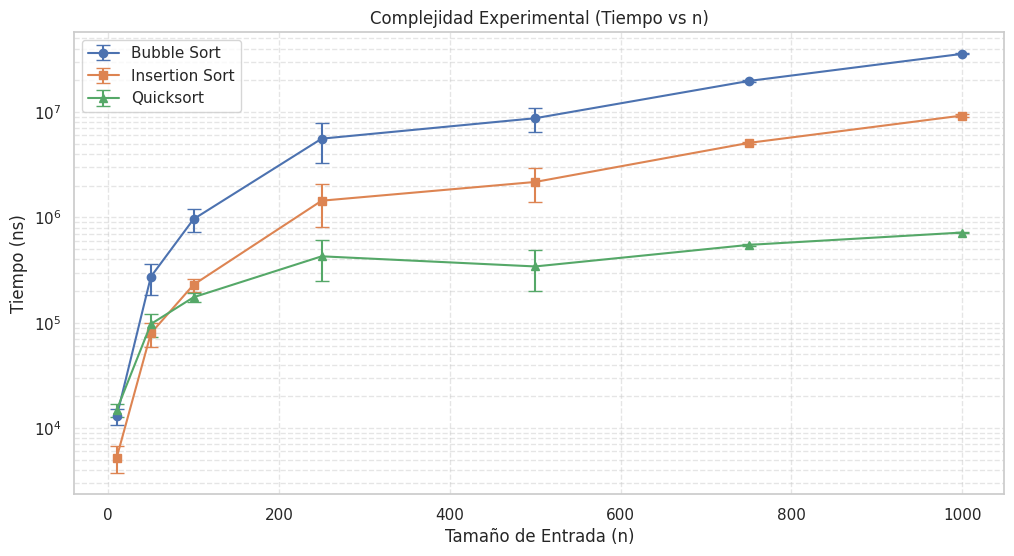

In [28]:
plt.figure(figsize=(12, 6))
plt.errorbar(df_stats['n'], df_stats['bubble_mean'], yerr=df_stats['bubble_std'], label='Bubble Sort', fmt='-o', capsize=5)
plt.errorbar(df_stats['n'], df_stats['insertion_mean'], yerr=df_stats['insertion_std'], label='Insertion Sort', fmt='-s', capsize=5)
plt.errorbar(df_stats['n'], df_stats['quicksort_mean'], yerr=df_stats['quicksort_std'], label='Quicksort', fmt='-^', capsize=5)

plt.title('Complejidad Experimental (Tiempo vs n)')
plt.xlabel('Tamaño de Entrada (n)')
plt.ylabel('Tiempo (ns)')
plt.legend()
plt.yscale('log')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

## 3. Análisis de Regresión Lineal
Validamos si los datos se ajustan a las complejidades teóricas:
- Bubble/Insertion Sort: $O(n^2)$
- Quicksort: $O(n \log n)$

In [29]:
# Regresión para Bubble Sort (n^2)
res_bubble = smf.ols(formula='Q("Bubble Sort") ~ np.power(n, 2)', data=df_raw).fit()
print("--- Regresión para Bubble Sort ---")
print(res_bubble.summary())

# Regresión para Insertion Sort (n^2)
res_insertion = smf.ols(formula='Q("Insertion Sort") ~ np.power(n, 2)', data=df_raw).fit()
print("\n--- Regresión para Insertion Sort ---")
print(res_insertion.summary())

# Regresión para Quicksort (n*log n)
res_quick = smf.ols(formula='Q("Quicksort") ~ n:np.log2(n)', data=df_raw).fit()
print("\n--- Regresión para Quicksort ---")
print(res_quick.summary())

--- Regresión para Bubble Sort ---
                            OLS Regression Results                            
Dep. Variable:       Q("Bubble Sort")   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     3784.
Date:                Sun, 15 Feb 2026   Prob (F-statistic):           2.39e-61
Time:                        09:20:08   Log-Likelihood:                -1100.9
No. Observations:                  70   AIC:                             2206.
Df Residuals:                      68   BIC:                             2210.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept

### Visualización del Ajuste de Regresión

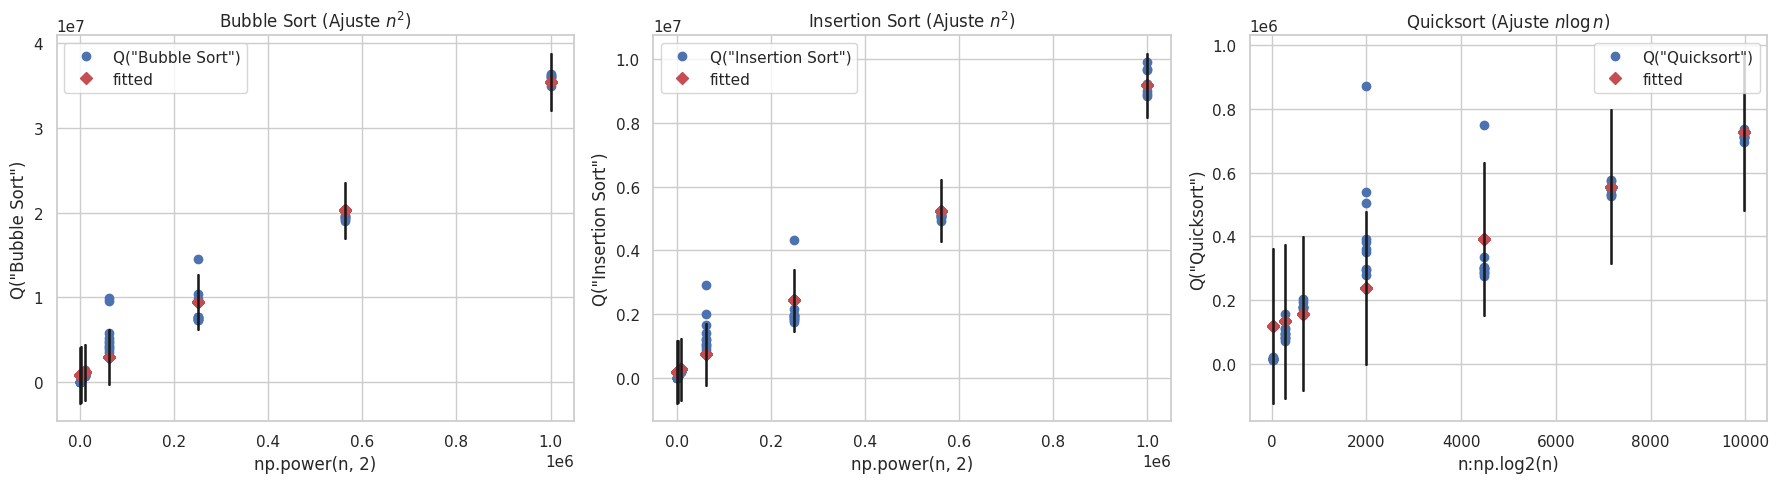

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sm.graphics.plot_fit(res_bubble, "np.power(n, 2)", ax=axes[0])
axes[0].set_title(r"Bubble Sort (Ajuste $n^2$)")

sm.graphics.plot_fit(res_insertion, "np.power(n, 2)", ax=axes[1])
axes[1].set_title(r"Insertion Sort (Ajuste $n^2$)")

sm.graphics.plot_fit(res_quick, "n:np.log2(n)", ax=axes[2])
axes[2].set_title(r"Quicksort (Ajuste $n \log n$)")

plt.tight_layout()
plt.show()